# ABE tutorial 4
## Using functional approximation

In this fourth tutorial let's dive deeper into how we use neural network models with RL. Now that we understand the concept of functional approximation, we can see how these neural network models are operating. We'll spend some time on some of the options when it comes to building neural networks for functional approximation, and go over some computational hurdles. 

Steps:
* Go over the building of a neural network
* Normalization
* Converting A2C to continous action spaces
* Test out the continuous A2C algorithm in new environments


# Building a Neural Network

We'll use pytorch as our python package to build neural networks. We've seen these before in our first 4 tutorials, but here let's dive into the details a little more.

The first thing to note is that we are using a sequential approach to building our neural networks. In this approach we just need to specify a network by providing an ordered list of layers. Let's take a look at how to do this below, by building a simple three layer network:

* **Input layer**: this is the layer where the data comes into the model. Let's assume there are 4 input variables.

* **First hidden layer**: this a layer of nodes that is connected to the input layer and will transform the input data, and pass these transformed values to the output layer. Let's assume this hidden layer has 32 nodes.

* **Output layer**: this output layer will take the transformed values and output values that can be used to inform what actions can be taken. Let's assume there are two actions that can be taken.

You should see below these 3 layers, and you should see how each layers shape coresponds to the data: e.g., 4 input values gets passed to the 32 nodes in the hidden layer, and how those 32 nodes pass those transformed values to the 2 actions in the output layer.



In [5]:
import torch
import torch.nn as nn

#build a simple two three layer model
my_net = nn.Sequential(
            nn.Linear(4, 32),
            nn.Linear(32, 32),
            nn.Linear(32, 2)
        )

print(my_net)

Sequential(
  (0): Linear(in_features=4, out_features=32, bias=True)
  (1): Linear(in_features=32, out_features=32, bias=True)
  (2): Linear(in_features=32, out_features=2, bias=True)
)


To see a little more about the network we can install torchsummary. Just make sure you are still in your virtual environment and run the following.

```
pip install torchsummary
```

Then you should be able to run

In [6]:
from torchsummary import summary

# Specify the input shape as a tuple
input_shape = (1, 4)

# Print the summary
summary(my_net, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 32]             160
            Linear-2                [-1, 1, 32]           1,056
            Linear-3                 [-1, 1, 2]              66
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


We can see in the  summary above that the model has 1282 parameters! These are all the weights and bias values that are associated with each edge.

In the book, we saw that these weights and biases on their own are really just linear equations applied to some inputs... and that to capture non-linear relationships we had to introduce activation functions. Let's do that now!

In [7]:
#build a simple two three layer model
my_net_2 = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

summary(my_net_2, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 32]             160
              ReLU-2                [-1, 1, 32]               0
            Linear-3                [-1, 1, 32]           1,056
              ReLU-4                [-1, 1, 32]               0
            Linear-5                 [-1, 1, 2]              66
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


By placing the RELU activation layers after each layer we are filtering out any nodes that are outputing negative values. This cutoff is what let's a neural network model non-linear relationships.

You'll notice that the model has the same number of weights and biases paramters. This is because the activation function is really just a filter and requires no new parameters. 

You'll notice too that there is no activation function applied after the output layer. This is because we want the output layer to output a continuous value and we want to keep negative values as an option. We'll see that for the output layer we have to think more about what kinds of outputs we want (continuous numeric, restricted to be between 0-1, ...etc) and that will determine how we build this last layer. Internally, however, with the hidden layers we will generally use RELU activation functions.

# Some useful layers

There are many kinds of layers we can build into our networks, we'll learn a few as we build our agents. Generally, these layers solve some problem for us, or allow our agents to experience the world in a different way. 

In this tutorial we'll learn about the Normalization layer. This layer solves a problem for us. As our agents are continuously learning and adjusting weights/biases in their neural networks, the size of those weights can get quite large, making subsequent changes to those weights/biases harder to adapt when learning. To make sure the weights/biases don't get to large, and allow our agents to be more flexible in learning, we will normalize the values of the weights/biases. This will still mean that larger weights and smaller weights will still be relatively the same their magnitudes will be reduced. This solves, or helps to solve, the computational issues of having very large weights/biases.

Let's see how to add that into our network. With the sequential approach we just have to stack the new layers in like lego blocks.

In [8]:
#build a simple two three layer model
my_net_3 = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.LayerNorm(32),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.LayerNorm(32),
            nn.Linear(32, 2)
        )

summary(my_net_3, input_shape)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 32]             160
              ReLU-2                [-1, 1, 32]               0
         LayerNorm-3                [-1, 1, 32]              64
            Linear-4                [-1, 1, 32]           1,056
              ReLU-5                [-1, 1, 32]               0
         LayerNorm-6                [-1, 1, 32]              64
            Linear-7                 [-1, 1, 2]              66
Total params: 1,410
Trainable params: 1,410
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


We can see that we have more parameters in this normalized model. These new parameters are used to normalize the weights/biases of each layer.

Again we don't add the layerNorm to the output layer as the magnitudes of output are meaningful and we want to keep these magnitudes.

# Learning in Neural Networks

We've seen how we can build neural networks using a lego like approach and using different kinds of layers. Let's see now how we can update the weights/biases of these layers so that the network can learn. To do this, let's:

* Simulate some data to use as input
* Measure how far the network predictions are from the "right" answer
* Adjust the weights and biases to make better predcitions
* Do this many times, until the network is makeing good predictions!

Text(0.5, 1.0, 'Scatter Plot of State Variable vs Expected Return')

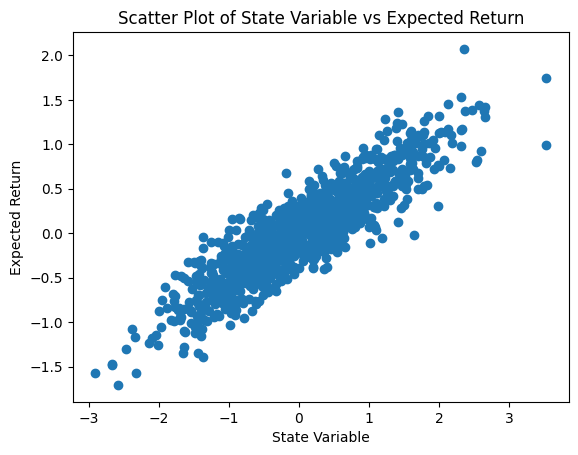

In [26]:
import numpy as np
import matplotlib.pyplot as plt

### Simulate some data

# let's say that the agent experiences some state variable... let's take 1000 observations
state_vars = np.random.normal(loc=0, scale=1, size=1000)

# let's say that those states are related to expected returns by some simple relationship (*0.5) and that there is some noise
expected_return = state_vars*0.5 + np.random.normal(loc=0, scale=0.25, size=1000)

#plot out the relationship
plt.scatter(x=state_vars, y=expected_return)
plt.xlabel("State Variable")
plt.ylabel("Expected Return")
plt.title("Scatter Plot of State Variable vs Expected Return")


Let's see if our nerual network can learn the relationship between state values and expected rewards. 

First let's make sure the inputs to our neural network fit our data: that is one input and one output.



In [27]:
## Build a simple network
my_net_test = nn.Sequential(
            nn.Linear(1, 32), # 1 input
            nn.ReLU(),
            nn.LayerNorm(32),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.LayerNorm(32),
            nn.Linear(32, 1) # 1 ouput
        )

summary(my_net_test, (1,1))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 32]              64
              ReLU-2                [-1, 1, 32]               0
         LayerNorm-3                [-1, 1, 32]              64
            Linear-4                [-1, 1, 32]           1,056
              ReLU-5                [-1, 1, 32]               0
         LayerNorm-6                [-1, 1, 32]              64
            Linear-7                 [-1, 1, 1]              33
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


LayerNorm is a little over kill for the simple model we are building (i.e., it is more useful in deeper networks that are learning continuously), but let's leave it in for the example.

Let's see how well this network does without learning (i.e., all the weights/biases are randomly selected)

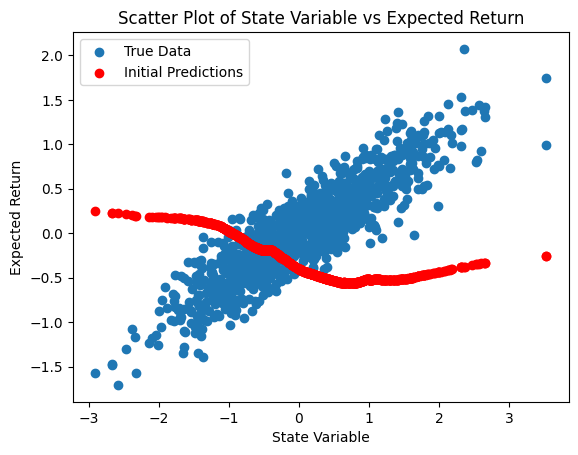

In [ ]:
# Convert state_vars to a PyTorch tensor and reshape to match the model's expected input shape
state_vars_tensor = torch.tensor(state_vars, dtype=torch.float32).view(-1, 1)

# Generate predictions with the untrained model
with torch.no_grad():  # Disable gradient tracking
    initial_predictions = my_net_test(state_vars_tensor)

# Plot initial predictions
plt.scatter(x=state_vars, y=expected_return, label='True Data')
plt.xlabel("State Variable")
plt.ylabel("Expected Return")
plt.title("Scatter Plot of State Variable vs Expected Return")
plt.scatter(state_vars, initial_predictions.numpy(), color='red', label='Initial Predictions')
plt.legend()
plt.show()

You can run this a few times and see the different shapes of the predictions. It should be random and will not fit the data very well at all.

Let's measure the differences between the predictions and the true expected rewards. This is called the loss function and will guide the learning of the nerual network, i.e., it will learn to reduce the loss function and get closer to the true expected rewards.


In [43]:
expected_return_tensor = torch.tensor(expected_return, dtype=torch.float32).view(-1, 1)

In [44]:
# Define the loss function
loss_fn = nn.MSELoss()

# Calculate the loss by calling loss_fn with predictions and targets
loss = loss_fn(initial_predictions, expected_return_tensor)

#take a look
loss

tensor(0.6760)

This loss value is the mean squared error, and is the sum of the squared differences between the true expected rewards and the predicted expected rewards. Let's see if we can reduce the MSE!

To do this we have to use an optimizer. This optimizer will perform backpropogation (short for backwards propogation of errors). So far we've done a forward pass by sending our state variable data through the network, i.e., starting at the initial layer, and outputing a prediction at the last layer. With backpropogation we will take the loss value and calculate how each weight in the network contributed to that loss. To do this calculation backpropogation uses the chain rule in calculus (as all functions in the neural network are differentiable!). The outputs of this calculation is called the gradient of the loss with respect to each weight. Essentially, telling us which weights are responsible for the loss (i.e., the difference between the observed and predicted values), and as a result which weights need to be update to make better predictions. 

Let's perform these steps:

In [57]:
# Define the optimizer
optimizer = torch.optim.Adam(my_net_test.parameters(), lr=0.01) #lr is the learning rate... i.e., how much to adjust the weights/biases when learning

# Forward pass: compute predictions and loss without torch.no_grad()
predictions = my_net_test(state_vars_tensor)  # state_vars_tensor is the input data tensor
loss_fn = nn.MSELoss()
loss = loss_fn(predictions, expected_return_tensor)

# Backpropagation and optimization
optimizer.zero_grad()  # Clear gradients for the next step
loss.backward()         # Backpropagation, compute gradients
optimizer.step()        # Update weights based on gradients

print(f"Loss after training step: {loss.item()}")

Loss after training step: 0.10162829607725143


You can run the above code a few times hopefully seeing the loss get smaller than the first loss.

But let's formalize these steps a little better, and write the steps into a loop!

In [58]:

# Define a loss function (Mean Squared Error) and an optimizer (Adam)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(my_net_test.parameters(), lr=0.01)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    
    # Forward pass: Compute predicted y by passing state_vars to the model
    predictions = my_net_test(state_vars_tensor)
    
    # Compute the loss
    loss = loss_fn(predictions, expected_return_tensor)
    
    # Zero gradients, backpropagation, and update the weights
    optimizer.zero_grad()   # Clear gradients for the next step
    loss.backward()         # Backpropagation, compute gradients
    optimizer.step()        # Update weights based on gradients
    
    # Print the loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')



Epoch [100/1000], Loss: 0.0624
Epoch [200/1000], Loss: 0.0622
Epoch [300/1000], Loss: 0.0622
Epoch [400/1000], Loss: 0.0621
Epoch [500/1000], Loss: 0.0619
Epoch [600/1000], Loss: 0.0619
Epoch [700/1000], Loss: 0.0618
Epoch [800/1000], Loss: 0.0618
Epoch [900/1000], Loss: 0.0617
Epoch [1000/1000], Loss: 0.0616


Let's look at how the trained model does now when compared to the observed data.

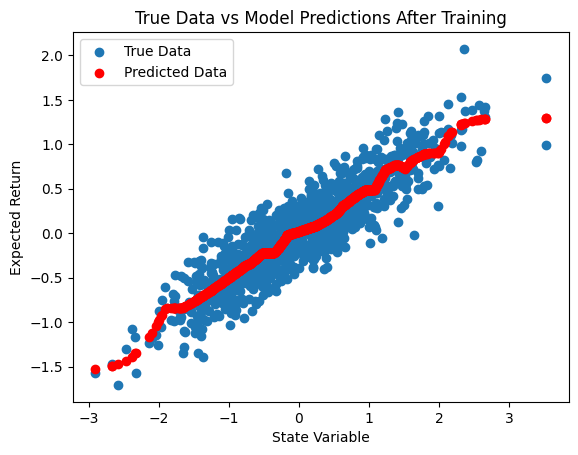

In [59]:
# Generate final predictions with the trained model
with torch.no_grad():
    final_predictions = my_net_test(state_vars_tensor)

# Plot the true data and the model's final predictions
plt.scatter(state_vars, expected_return, label='True Data')
plt.scatter(state_vars, final_predictions.numpy(), color='red', label='Predicted Data')
plt.xlabel("State Variable")
plt.ylabel("Expected Return")
plt.legend()
plt.title("True Data vs Model Predictions After Training")
plt.show()

We should see that the model predictions are much better aligned with the true expected returns! 

Note: we know the true relationship is a simple linear line with 0.5 slope. But we can see that the red line is trying to find more complex relationships, and is overfitting the data! There are ways to minimize overfitting of a neural network model and we'll see some of these as we go through some more RL examples. But it is usually a good idea to overfit our models first then take steps to reduce overfiting (e.g., regularize).

From the examples above we should now have an introductory sense of how we can build and train neural network models! We'll build on these skills in these tutorials going forward. The first thing we'll do is see how we can change the outputs of our neural networks to allow for continuous actions! We'll do this in the next tutorial.